<a href="https://colab.research.google.com/github/esther-pui/WQF7009-Assignment-1/blob/main/stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 1: Exploratory Data Analysis**

In [2]:
import pandas as pd
# Makes sure we see all columns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

class DataLoader():
    def __init__(self):
        self.data = None

    def load_dataset(self, path="healthcare-dataset-stroke-data.csv"):
        self.data = pd.read_csv(path)

    def preprocess_data(self):
        # One-hot encode all categorical columns
        categorical_cols = ["gender",
                            "ever_married",
                            "work_type",
                            "Residence_type",
                            "smoking_status"]
        encoded = pd.get_dummies(self.data[categorical_cols],
                                prefix=categorical_cols)

        # Update data with new columns
        self.data = pd.concat([encoded, self.data], axis=1)
        self.data.drop(categorical_cols, axis=1, inplace=True)

        # Impute missing values of BMI
        self.data.bmi = self.data.bmi.fillna(0)

        # Drop id as it is not relevant
        self.data.drop(["id"], axis=1, inplace=True)

        # Standardization
        # Usually we would standardize here and convert it back later
        # But for simplification we will not standardize / normalize the features

    def get_data_split(self):
        X = self.data.iloc[:,:-1]
        y = self.data.iloc[:,-1]
        return train_test_split(X, y, test_size=0.20, random_state=2021)

    def oversample(self, X_train, y_train):
        oversample = RandomOverSampler(sampling_strategy='minority')
        # Convert to numpy and oversample
        x_np = X_train.to_numpy()
        y_np = y_train.to_numpy()
        x_np, y_np = oversample.fit_resample(x_np, y_np)
        # Convert back to pandas
        x_over = pd.DataFrame(x_np, columns=X_train.columns)
        y_over = pd.Series(y_np, name=y_train.name)
        return x_over, y_over

(5110, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
col:  id


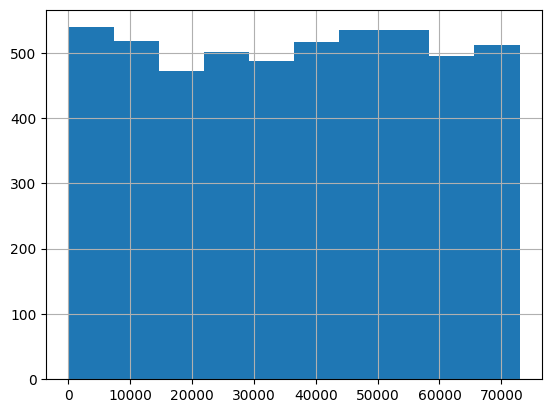

col:  gender


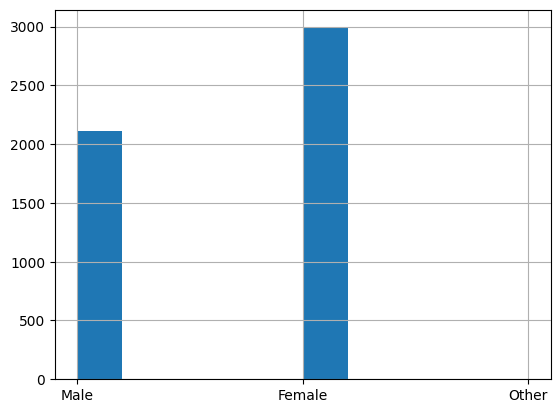

col:  age


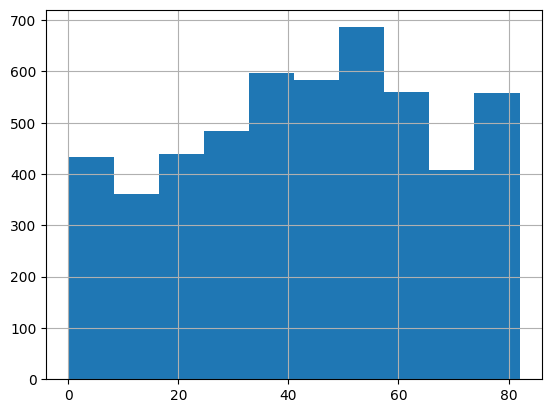

col:  hypertension


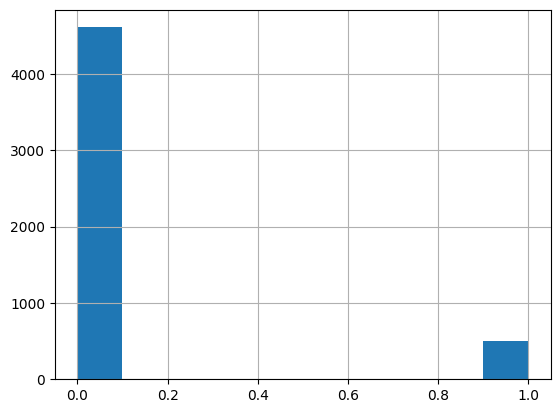

col:  heart_disease


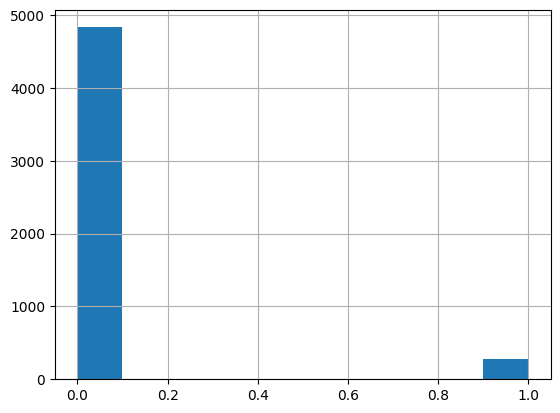

col:  ever_married


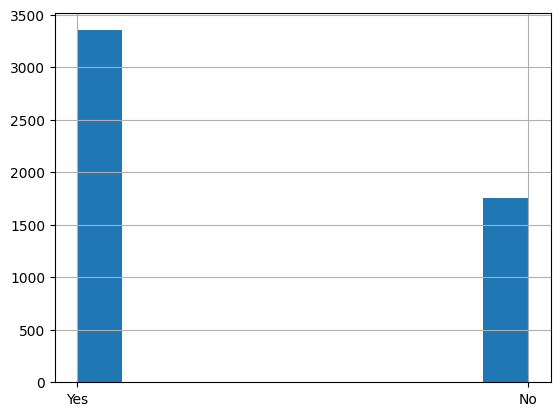

col:  work_type


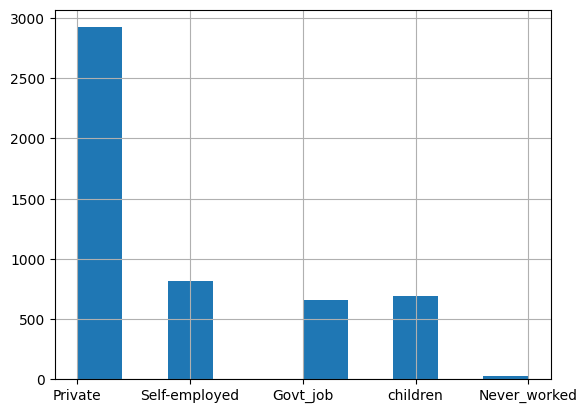

col:  Residence_type


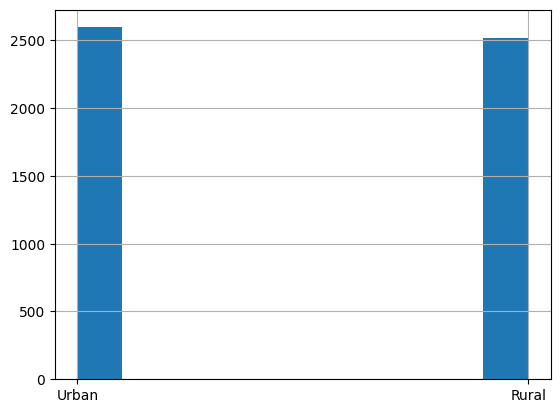

col:  avg_glucose_level


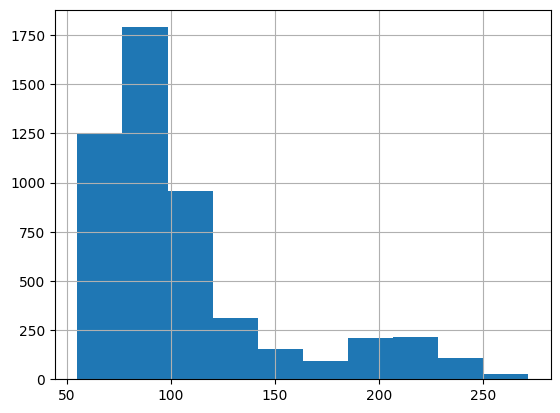

col:  bmi


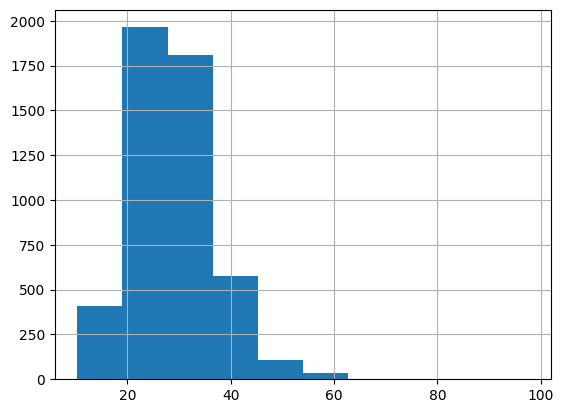

col:  smoking_status


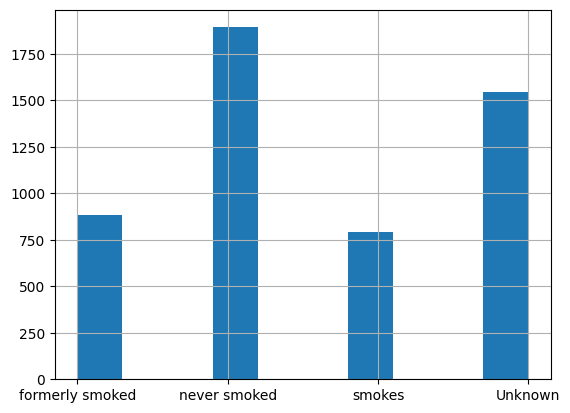

col:  stroke


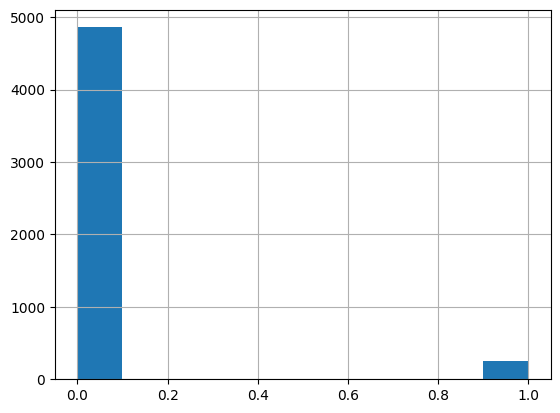

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,67.0,0,1,228.69,36.6,1
1,True,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,61.0,0,0,202.21,0.0,1
2,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,80.0,0,1,105.92,32.5,1
3,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,49.0,0,0,171.23,34.4,1
4,True,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,79.0,1,0,174.12,24.0,1


In [3]:
# %% Imports
import matplotlib.pyplot as plt

# %% Load data
data_loader = DataLoader()
data_loader.load_dataset()
data = data_loader.data

# %% Show head
print(data.shape)
data.head()

# %% Show general statistics
data.info()

# %% Show histogram for all columns
columns = data.columns
for col in columns:
    print("col: ", col)
    data[col].hist()
    plt.show()

# %% Show preprocessed dataframe
data_loader.preprocess_data()
data_loader.data.head()



# **Task 2: Create XAI  explainer  (SHAP)**

In [23]:
# %% Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import shap
import numpy as np

# %% Load and preprocess data
data_loader = DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()

# Split the data for evaluation
X_train, X_test, y_train, y_test = data_loader.get_data_split()

# Oversample
X_train, y_train = data_loader.oversample(X_train, y_train)

# %% Fit model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Task 2: Create XAI  explainer  (SHAP)
# %% SHAP for binary classification
explainer = shap.TreeExplainer(rf, feature_names=X_train.columns)
X_background = X_train.sample(200, random_state=42)
shap_values = explainer.shap_values(X_background)

# print("SHAP output shape:", shap_values.shape)
# print(f"Class 0 array shape: {shap_values[0].shape}")
# print(f"Class 1 array shape: {shap_values[1].shape}")

# %% Local explanation
shap.initjs()

# Task 3
# Local Explainer (Force plot)
patient_index = 1
patient_row = X_test.iloc[[patient_index]]  # DataFrame with 1 row
local_shap = explainer.shap_values(patient_row)  # list of arrays

print(type(local_shap))
print(np.array(local_shap).shape)

patient_shap = local_shap[0, :, 1]   # class 1, first (and only) row
patient_features = patient_row.iloc[0]  # Series

# patient_features = X_train.iloc[patient_index].values
base_value = explainer.expected_value[1]

print("Patient features:")
print(patient_features)
print("\nPatient shap:", patient_shap)

prediction = rf.predict(X_test.iloc[[patient_index]])[0]
print("\nPrediction:", prediction)

# Task 4
# %% # Global explanation (summary plot)
sample = X_test.sample(200, random_state=42)
global_shap = explainer.shap_values(sample)[1]

F1 Score: 0.5168545627909585
Accuracy: 0.9422700587084148
SHAP output shape: (200, 21, 2)
Class 0 array shape: (21, 2)
Class 1 array shape: (21, 2)


<class 'numpy.ndarray'>
(1, 21, 2)
Patient features:
gender_Female                     False
gender_Male                        True
gender_Other                      False
ever_married_No                   False
ever_married_Yes                   True
work_type_Govt_job                False
work_type_Never_worked            False
work_type_Private                  True
work_type_Self-employed           False
work_type_children                False
Residence_type_Rural              False
Residence_type_Urban               True
smoking_status_Unknown            False
smoking_status_formerly smoked    False
smoking_status_never smoked        True
smoking_status_smokes             False
age                                43.0
hypertension                          0
heart_disease                         0
avg_glucose_level                 91.13
bmi                                33.9
Name: 2813, dtype: object

Patient shap: [-8.06893812e-03 -7.67290124e-03  7.80087780e-07  3.19672795e-03
 

# **Task 3: Visualize local Explainer using Force plot**

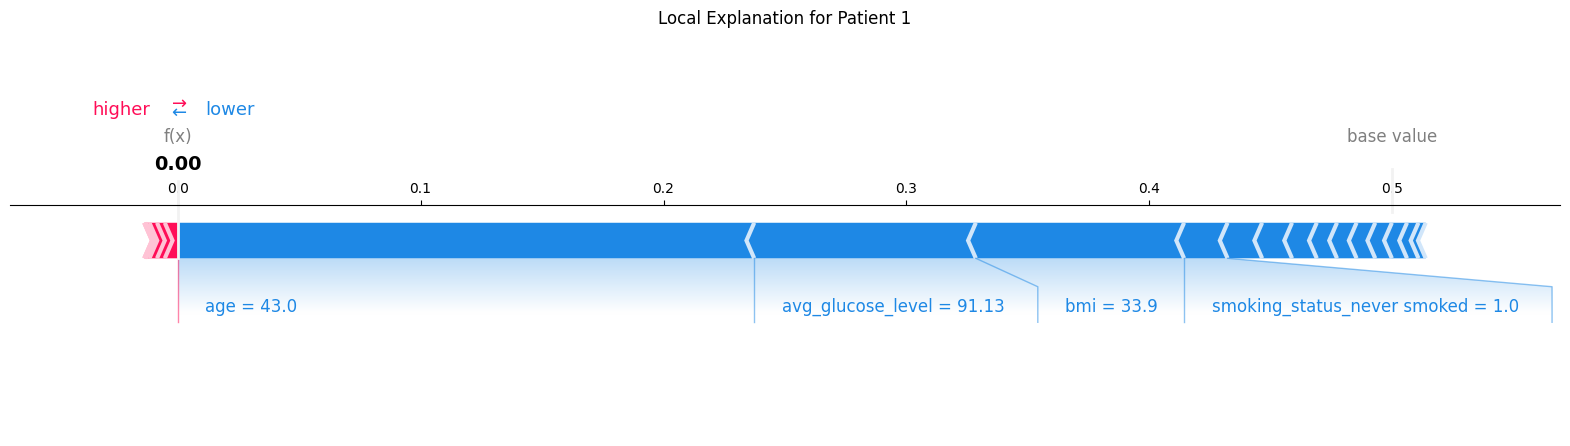

In [45]:
features_1d = patient_features.values
feature_names = patient_features.index

shap.plots.force(
    base_value,
    patient_shap,
    features_1d,
    feature_names=feature_names,
    matplotlib=True,
    show=False
)

plt.title(f"Local Explanation for Patient {patient_index}", y=1.75)
plt.show()


# **Task 4: Visualize global Explainer using Summary plot**

<class 'numpy.ndarray'>
(200, 21, 2)
global_shap shape: (200, 21)
sample shape: (200, 21)


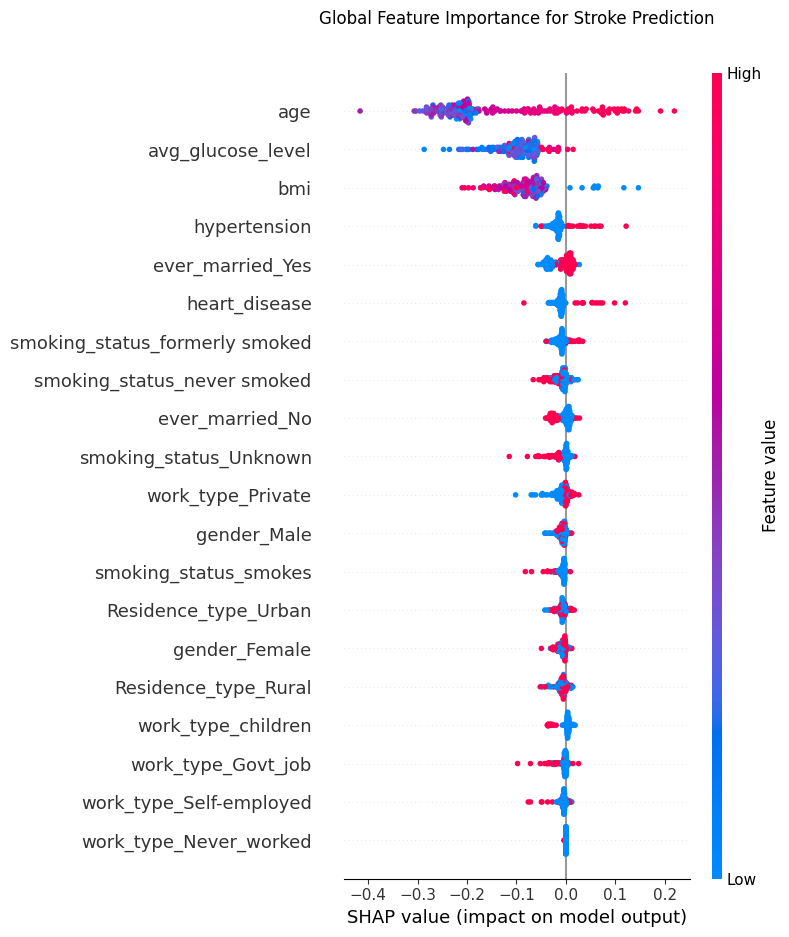

In [49]:
# Sample a subset
sample = X_test.sample(200, random_state=42)

# Compute SHAP values for the subset
shap_values = explainer.shap_values(sample)

print(type(shap_values))
print(np.array(shap_values).shape)

if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # take class 1 (stroke-positive)
    global_shap = shap_values[:, :, 1]
else:
    global_shap = shap_values[1]

print("global_shap shape:", global_shap.shape)
print("sample shape:", sample.shape)

# Beeswarm plot
plt.figure(figsize=(10, 6))
shap.summary_plot(global_shap, sample, show=False)
plt.title("Global Feature Importance for Stroke Prediction", y=1.05)
plt.tight_layout()
plt.show()


# **Task 5: Prepare in three slides, explaining the model using SHAP**
1. As data scientist
2. As Doctor
3. As Patient

Link:
https://docs.google.com/presentation/d/1ifAtNchybJmGedUIJJJP-_OYrf3veIjsErKGy-Hrpdk/edit?usp=sharing

# **Task 6 : Create Deep SHAP as an explainer and explain a chosen black box model different from Task 2.**

# **Train Model**

In [63]:
x_train, x_test, y_train, y_test = data_loader.get_data_split()

# fix imbalance
x_train_over, y_train_over = data_loader.oversample(x_train, y_train)

# train
model = RandomForestClassifier(random_state=42)
model.fit(x_train_over, y_train_over)

print("Model training is completed!")

Model training is completed!


Epoch 1/10


<>:45: SyntaxWarning: invalid escape sequence '\L'
<>:45: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipython-input-607511227.py:45: SyntaxWarning: invalid escape sequence '\L'
  print('\Local plot')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6342 - loss: 3.7526
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7388 - loss: 0.5596
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7723 - loss: 0.4991
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7688 - loss: 0.4812
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7910 - loss: 0.4549
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7806 - loss: 0.4654
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7749 - loss: 0.4761
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7862 - loss: 0.4682
Epoch 9/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7988 - loss: 0.4441
Epoch 10/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7921 - loss: 0.4534
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
157/157 ━━━━━

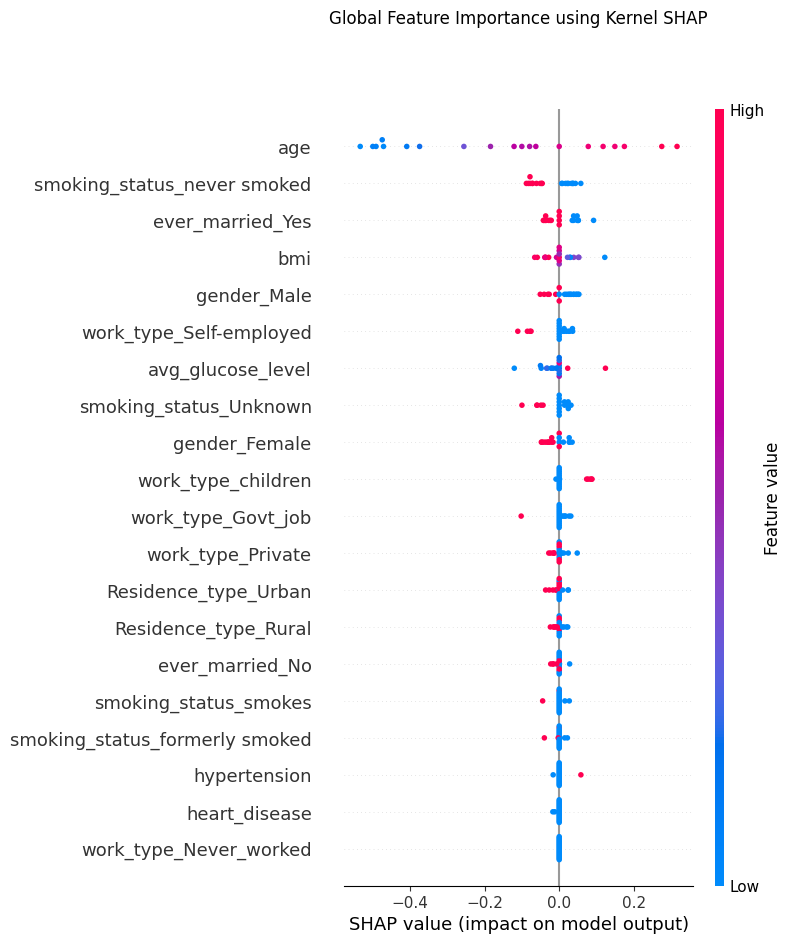

\Local plot


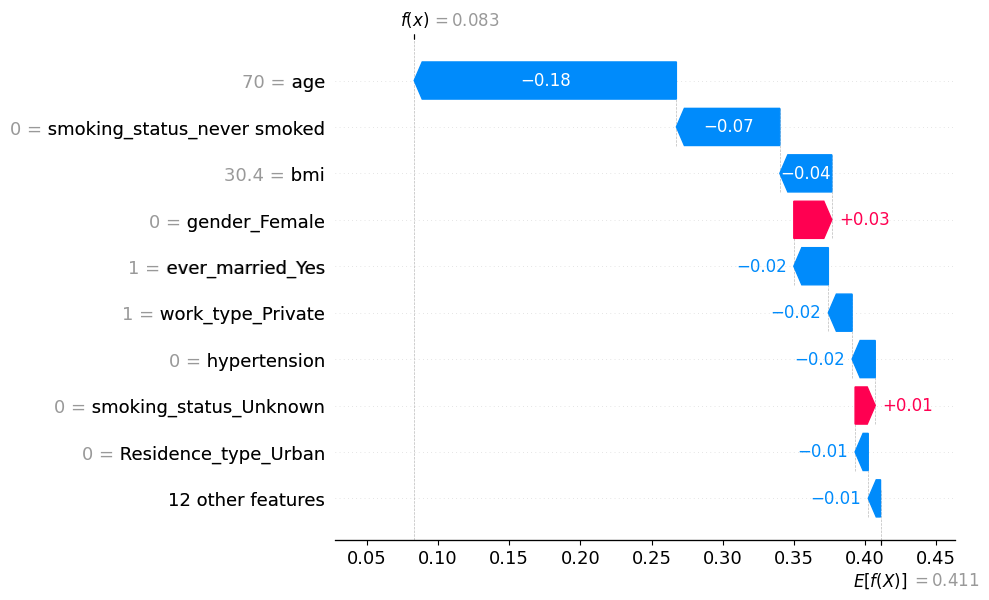

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# blackbox = simple neural network
X_train_nn = x_train_over.astype(np.float32).values
X_test_nn = x_test.astype(np.float32).values
# use oversampled labels
y_train_nn = tf.keras.utils.to_categorical(y_train_over)

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_nn, y_train_nn, epochs=10, batch_size=32, verbose=1)

# kernel shap plot
background = X_train_nn[np.random.choice(X_train_nn.shape[0], 50, replace=False)]
X_subset = X_test_nn[:20]

def predict_stroke(x):
    return model.predict(x)[:, 1]

explainer = shap.KernelExplainer(predict_stroke, background)
shap_values = explainer.shap_values(X_subset, nsamples=100)  # shape: (20, 21)

# global
print('\nGlobal plot')
plt.title("Global Feature Importance using Kernel SHAP", y=1.1)
shap.summary_plot(shap_values, X_subset, feature_names=X_test.columns)

# local
patient_shap = shap_values[1]  # class 1, single patient
patient_features = X_subset[0] # same single patient

patient_explanation = shap.Explanation(
    values=patient_shap,
    base_values=explainer.expected_value,  # just the float
    data=patient_features,
    feature_names=X_test.columns
)
print('\Local plot')
shap.plots.waterfall(patient_explanation)
